In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39983")
client

<Client: 'tcp://127.0.0.1:39983' processes=8 threads=40, memory=157.39 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import xrft
import xwavelet
from scipy.interpolate import interp2d, bisplrep, bisplev, griddata
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,:]

array([1421280, 1423440, 1425600, 1427760, 1429920, 1432080, 1434240,
       1436400, 1438560, 1440720, 1442880, 1445040, 1447200, 1449360,
       1451520, 1453680, 1455840, 1458000, 1460160, 1462320, 1464480,
       1466640, 1468800, 1470960, 1473120, 1475280, 1477440, 1479600,
       1481760, 1483920, 1486080, 1488240, 1490400, 1492560, 1494720,
       1496880, 1499040, 1501200, 1503360, 1505520, 1507680, 1509840,
       1512000, 1514160, 1516320, 1518480, 1520640, 1522800, 1524960,
       1527120, 1529280, 1531440, 1533600, 1535760, 1537920, 1540080,
       1542240, 1544400, 1546560, 1548720, 1550880, 1553040, 1555200,
       1557360, 1559520, 1561680, 1563840, 1566000, 1568160, 1570320,
       1572480, 1574640, 1576800])

In [6]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

dCs = 1e-5
Cs = xr.open_zarr(op.join(tdgs,'5Dave/Max_sound-speed/run1967/')).Cs

xo = 50e3
s = xr.DataArray(np.arange(.5,10.5,.5), dims=['scale'], 
                 coords={'scale':np.arange(.5,10.5,.5)}
                )

/tmp/ipykernel_13683/3829648471.py:11: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  Cs = xr.open_zarr(op.join(tdgs,'5Dave/Max_sound-speed/run1967/')).Cs


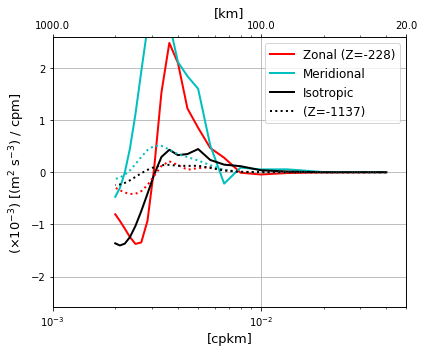

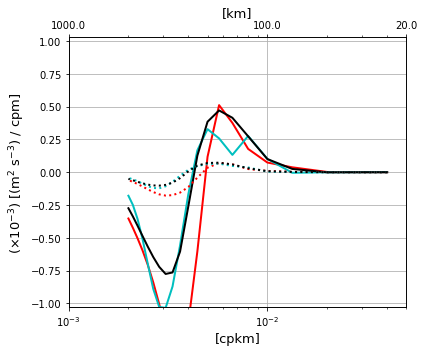

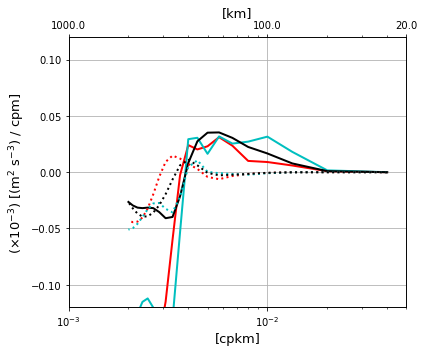

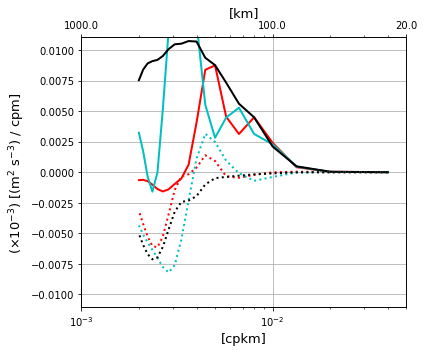

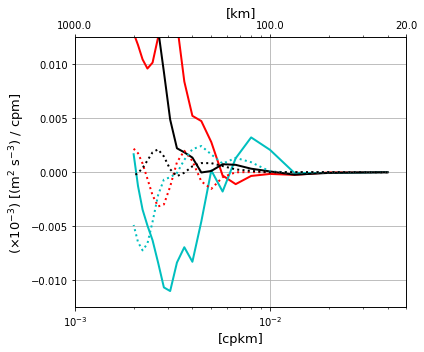

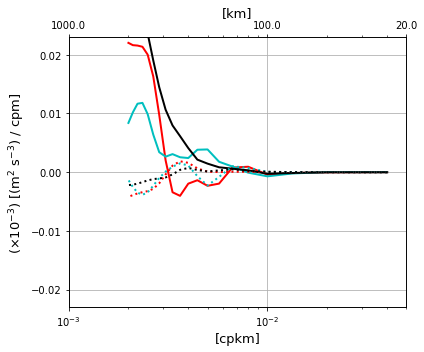

In [9]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100

yy = yystart

for reg in range(len(xs)):
    for year in years[yystart:]:
        if year == years[yystart]:
            mtimes = ntimes[yy,:dd+1]
        else:
            mtimes = ntimes[yy]
        for itime in mtimes:

            dsb = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Ensemble-mean/%2dmembers/15N-50N_%010d.zarr'
                                       % (year,len(nmembs),itime))
                              ).isel(time=0
                                    ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                          YG=slice(ys[reg]-5,ys[reg]+5),
                                          XC=slice(xs[reg]-5,xs[reg]+5),
                                          XG=slice(xs[reg]-5,xs[reg]+5)
                                         ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})

            for nmemb in nmembs:
                if nmemb == 0:
                    ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                 % (nmemb,year)), 
                                         grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                         prefix=['diag_ocnTave'], delta_t=2e2,
                                         iters=itime, 
                                        ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                              YG=slice(ys[reg]-5,ys[reg]+5),
                                              XC=slice(xs[reg]-5,xs[reg]+5),
                                              XG=slice(xs[reg]-5,xs[reg]+5)
                                             ).isel(time=0
                                                   ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                else:
                    ds = xr.concat([ds, 
                                    open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                            % (nmemb,year)), 
                                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                    prefix=['diag_ocnTave'], delta_t=2e2,
                                                    iters=itime, 
                                                   ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                                         YG=slice(ys[reg]-5,ys[reg]+5),
                                                         XC=slice(xs[reg]-5,xs[reg]+5),
                                                         XG=slice(xs[reg]-5,xs[reg]+5)
                                                        ).isel(time=0
                                                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                                   ], dim='nmemb')

            # ds = ds.chunk({'nmemb':6})
            ds.coords['nmemb'] = ('nmemb',nmembs)

            grid = Grid(ds, periodic=[])
            
            theta = ds.THETA.where(ds.maskC!=0.)
            salt = ds.SALT.where(ds.maskC!=0.)

            rho_til = grid.interp(rhoConst*(1. - grav*(-grid.cumsum((Cs+dCs)**-2*ds.drF, 'Z',
                                                                    boundary='extend')
                                                      )),
                                  'Z', boundary='extend'
                                 )
            pres = rhoConst*grav*(-ds.Z) * 1e-4
            rho = xr.apply_ufunc(densjmd95, salt, theta, 
                                 pres, 
                                 dask='parallelized', output_dtypes=[float,]
                                )
            b = -grav*(rho - rho_til) / rhoConst
            
            bp = (b - b.mean('nmemb',skipna=True)).isel(Z=[14,24])
            wp = grid.interp((ds.WVEL - dsb.WVEL).reset_coords(drop=True), 
                             'Z',boundary='extend').isel(Z=[14,24])
            

            dx = grid.interp(ds.dxC,'X',boundary='extend').isel(YC=slice(2,-2),XC=slice(2,-2)).mean(skipna=True)
            dy = grid.interp(ds.dyC,'Y',boundary='extend').isel(YC=slice(2,-2),XC=slice(2,-2)).mean(skipna=True)
            N = bp.shape

            bp = xr.DataArray(bp.data, dims=bp.dims, 
                              coords={'nmemb':bp.nmemb,'Z':bp.Z,
                                      'YC':np.arange(0,N[-2]*dy,dy),
                                      'XC':np.arange(0,N[-1]*dx,dx)}
                             )
            wp = xr.DataArray(wp.data, dims=wp.dims, 
                              coords={'nmemb':wp.nmemb,'Z':wp.Z,
                                      'YC':np.arange(0,N[-2]*dy,dy),
                                      'XC':np.arange(0,N[-1]*dx,dx)}
                             )
        
            
            ntheta = 36
            iso_cs = xwavelet.wvlt_cross_spectrum(
                    wp, bp, s, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )


            fig, ax = plt.subplots(figsize=(6,5))
            fig.set_tight_layout(True)
            ax2 = ax.twiny()
            ax.plot((iso_cs.scale)**-1*1e3, iso_cs.isel(angle=0,Z=0).mean(['nmemb'])*1e3,
                    'r', lw=2, label=r"Zonal (Z=-228)")
            ax.plot((iso_cs.scale)**-1*1e3, iso_cs.isel(angle=ntheta//2//2-1,Z=0).mean(['nmemb'])*1e3,
                    'c', lw=2, label=r"Meridional")
            ax.plot((iso_cs.scale)**-1*1e3, iso_cs.isel(Z=0).mean(['nmemb','angle'])*1e3,
                    'k', lw=2, label=r"Isotropic")
            ax.plot((iso_cs.scale)**-1*1e3, iso_cs.isel(angle=0,Z=1).mean(['nmemb'])*1e3,
                    'r:', lw=2)
            ax.plot((iso_cs.scale)**-1*1e3, iso_cs.isel(angle=ntheta//2//2-1,Z=1).mean(['nmemb'])*1e3,
                    'c:', lw=2)
            ax.plot((iso_cs.scale)**-1*1e3, iso_cs.isel(Z=1).mean(['nmemb','angle'])*1e3,
                    'k:', lw=2, label=r"(Z=-1137)")
            ax.set_xscale('log')
#             ax.set_yscale('log')
            ax2.set_xscale('log')
#             ax2.set_yscale('log')
            ax.set_xlim([1e-3,5e-2])
            ax2.set_xlim([1e-3,5e-2])
            ax2.set_xticks([1e-3,1e-2,5e-2])
            ax2.set_xticklabels([1e3,1e2,2e1])
            Meta = np.fmax(np.fmax(np.abs(iso_cs.isel(Z=0).mean(['nmemb','angle'])).max(skipna=True).values*1e3,
                                   np.abs(iso_cs.isel(Z=0,angle=0).mean(['nmemb'])).max(skipna=True).values*1e3),
                           np.abs(iso_cs.isel(angle=ntheta//2//2-1,Z=0).mean(['nmemb'])).max(skipna=True).values*1e3
                          )
            ax.set_ylim([-Meta*.75, Meta*.75])
            ax.set_xlabel(r"[cpkm]", fontsize=13)
            ax2.set_xlabel(r"[km]", fontsize=13)
            ax.set_ylabel(r"($\times 10^{-3}$) [(m$^2$ s$^{-3}$) / cpm]", fontsize=13)
            ax.grid(True)
            if reg == 0:
                ax.legend(loc='upper right', fontsize=12)
            plt.savefig(op.join('/tank/topog/tuchida/Wavelet-spectrum/Figs/wb-spec_Region%02d.pdf' % reg))
            plt.show()